# Example of how to use the nuQLOUD framework
In this notebook, we demonstrate how to use the nuQLOUD framework on real data. The used data is part of the publication and consists of one 48 hpf zebrafish embryo and contains the following annotations.
* `sample`: Name of the sample. Corresponds to the image file name.
* `cell id`: Unique number identifying the cell. Has to be > 0 for use with voro++.
* `x`, `y`, `z`: Coordinates of nuclei in µm.
* `label`: Name of the genetic marker quantified under `expression`. In this example only the expression of the neural marker neural beta tubulin (NBT) is available.
* `expression`: Binary classification of individual cells into marker expressing (`True`) or non-expressing (`False`).

Note that results such as motif and archetype distributions may differ slighly from the publication, since here we only use one sample and not the whole data set.

In [97]:
import nuqloud
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import vedo
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
vedo.settings.notebookBackend = 'k3d'
vedo.settings.k3dPointShader = '3d'

## Load data
Here we load the data into a pandas DataFrame.

In [32]:
df = pd.read_csv('example_data/in_toto_nbt.csv').drop(['Unnamed: 0'], axis=1)
df

,sample,cell id,x,y,z,label,expression
0,nbt-dapi-fish03,1,378.496,155.439,527.769,nbt,True
1,nbt-dapi-fish03,2,230.438,2698.180,306.026,nbt,False
2,nbt-dapi-fish03,3,385.913,433.214,522.045,nbt,True
3,nbt-dapi-fish03,4,415.232,767.900,388.000,nbt,False
4,nbt-dapi-fish03,5,338.258,2164.180,398.869,nbt,False
...,...,...,...,...,...,...,...
120969,nbt-dapi-fish03,120970,254.367,2207.510,402.400,nbt,False
120970,nbt-dapi-fish03,120971,561.140,185.129,308.610,nbt,False
120971,nbt-dapi-fish03,120972,547.410,156.967,319.907,nbt,False
120972,nbt-dapi-fish03,120973,435.194,220.135,393.341,nbt,False


Visualisation of the segmented data with NBT expressing cells colour coded in red.

In [35]:
vedo.show(vedo.Points(df.loc[( df['expression']==False), list('xyz')].values).color('grey'),
          vedo.Points(df.loc[( df['expression']==True), list('xyz')].values).color('red'))

Plot(antialias=True, axes=['x', 'y', 'z'], axes_helper=1.0, background_color=16777215, camera=[2, -3, 0.2, 0.0…

## Generate restricted Voronoi diagram and organisational features
First, we generate a restricted Voronoi diagram using our modified version of voro++. The modification is that we can call a radially restricted Voronoi diagram from the command line (this is not implemented in the original voro++ code).
Then we evaluate the Voronoi diagram and generate features from it. Moreover, we generate a kernel density estimation at different length scales (multi scale density). 

In [36]:
df = nuqloud.Voronoi.voronoi_restricted(df)
df = nuqloud.FeatureGeneration.voronoi_features(df)
nuqloud.FeatureGeneration.multi_scale_density(df, np.arange(5,44,5))

voronoi density:   2%|▏         | 2344/120974 [00:02<01:48, 1093.68it/s]/home/d.imb.unizh.ch/maxb/anaconda3/envs/max_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/d.imb.unizh.ch/maxb/anaconda3/envs/max_env/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/d.imb.unizh.ch/maxb/anaconda3/envs/max_env/lib/python3.7/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/home/d.imb.unizh.ch/maxb/anaconda3/envs/max_env/lib/python3.7/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
/home/d.imb.unizh.ch/maxb/anaconda3/envs/max_env/lib/python3.7/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret /

['shell 5',
 'shell 10',
 'shell 15',
 'shell 20',
 'shell 25',
 'shell 30',
 'shell 35',
 'shell 40']

## Visualisation
Here we illustrate the distributions of organisational features on our test data in 3D by colouring the points according to their feature values. Replace `shell 10` with any other feature value (see below) to explore their distributions).

In [39]:
vedo.show(nuqloud.Visualisation.show_features(
    df,
    ['shell 10']),
)

Plot(antialias=True, axes=['x', 'y', 'z'], axes_helper=1.0, background_color=16777215, camera=[2, -3, 0.2, 0.0…

## Organisational motifs
We now use a 11 component GMM to identify organisational motifs. For that we first z-score our features to make them comparable.

### Normalisation
The following features will be used for analysis and are z-scored to make them comparable.

In [40]:
features = [
    'voronoi volume',
    'centroid offset', 
    'n neighbours',
    'density voronoi mean', 
    'density voronoi std',
    'neighbourhood voronoi volume mean', 
    'neighbourhood voronoi volume std',
    'neighbourhood n neighbours mean', 
    'neighbourhood n neighbours std',
    'neighbourhood centroid offset mean',
    'neighbourhood centroid offset std', 
    'shell 10',  
    'shell 20',
    'shell 30', 
]

In [44]:
features_scaled = []
for f in tqdm.tqdm(features):
    X = df[f].values
    name_scaled = f + ' scaled'
    scaler = StandardScaler().fit(X.reshape(-1, 1))
    df[name_scaled] = scaler.transform(X.reshape(-1,1))
    features_scaled.append(name_scaled)

100%|██████████| 14/14 [00:00<00:00, 250.93it/s]


### Gaussian Mixture Model
We use a Gaussian mixture model to identify organisational motifs -- cells with similar organisational profile.

In [ ]:
df.dropna(subset=features_scaled, inplace=True)
df['motifs'] = GaussianMixture(n_components=11).fit_predict(df[features_scaled].values)

([], [])

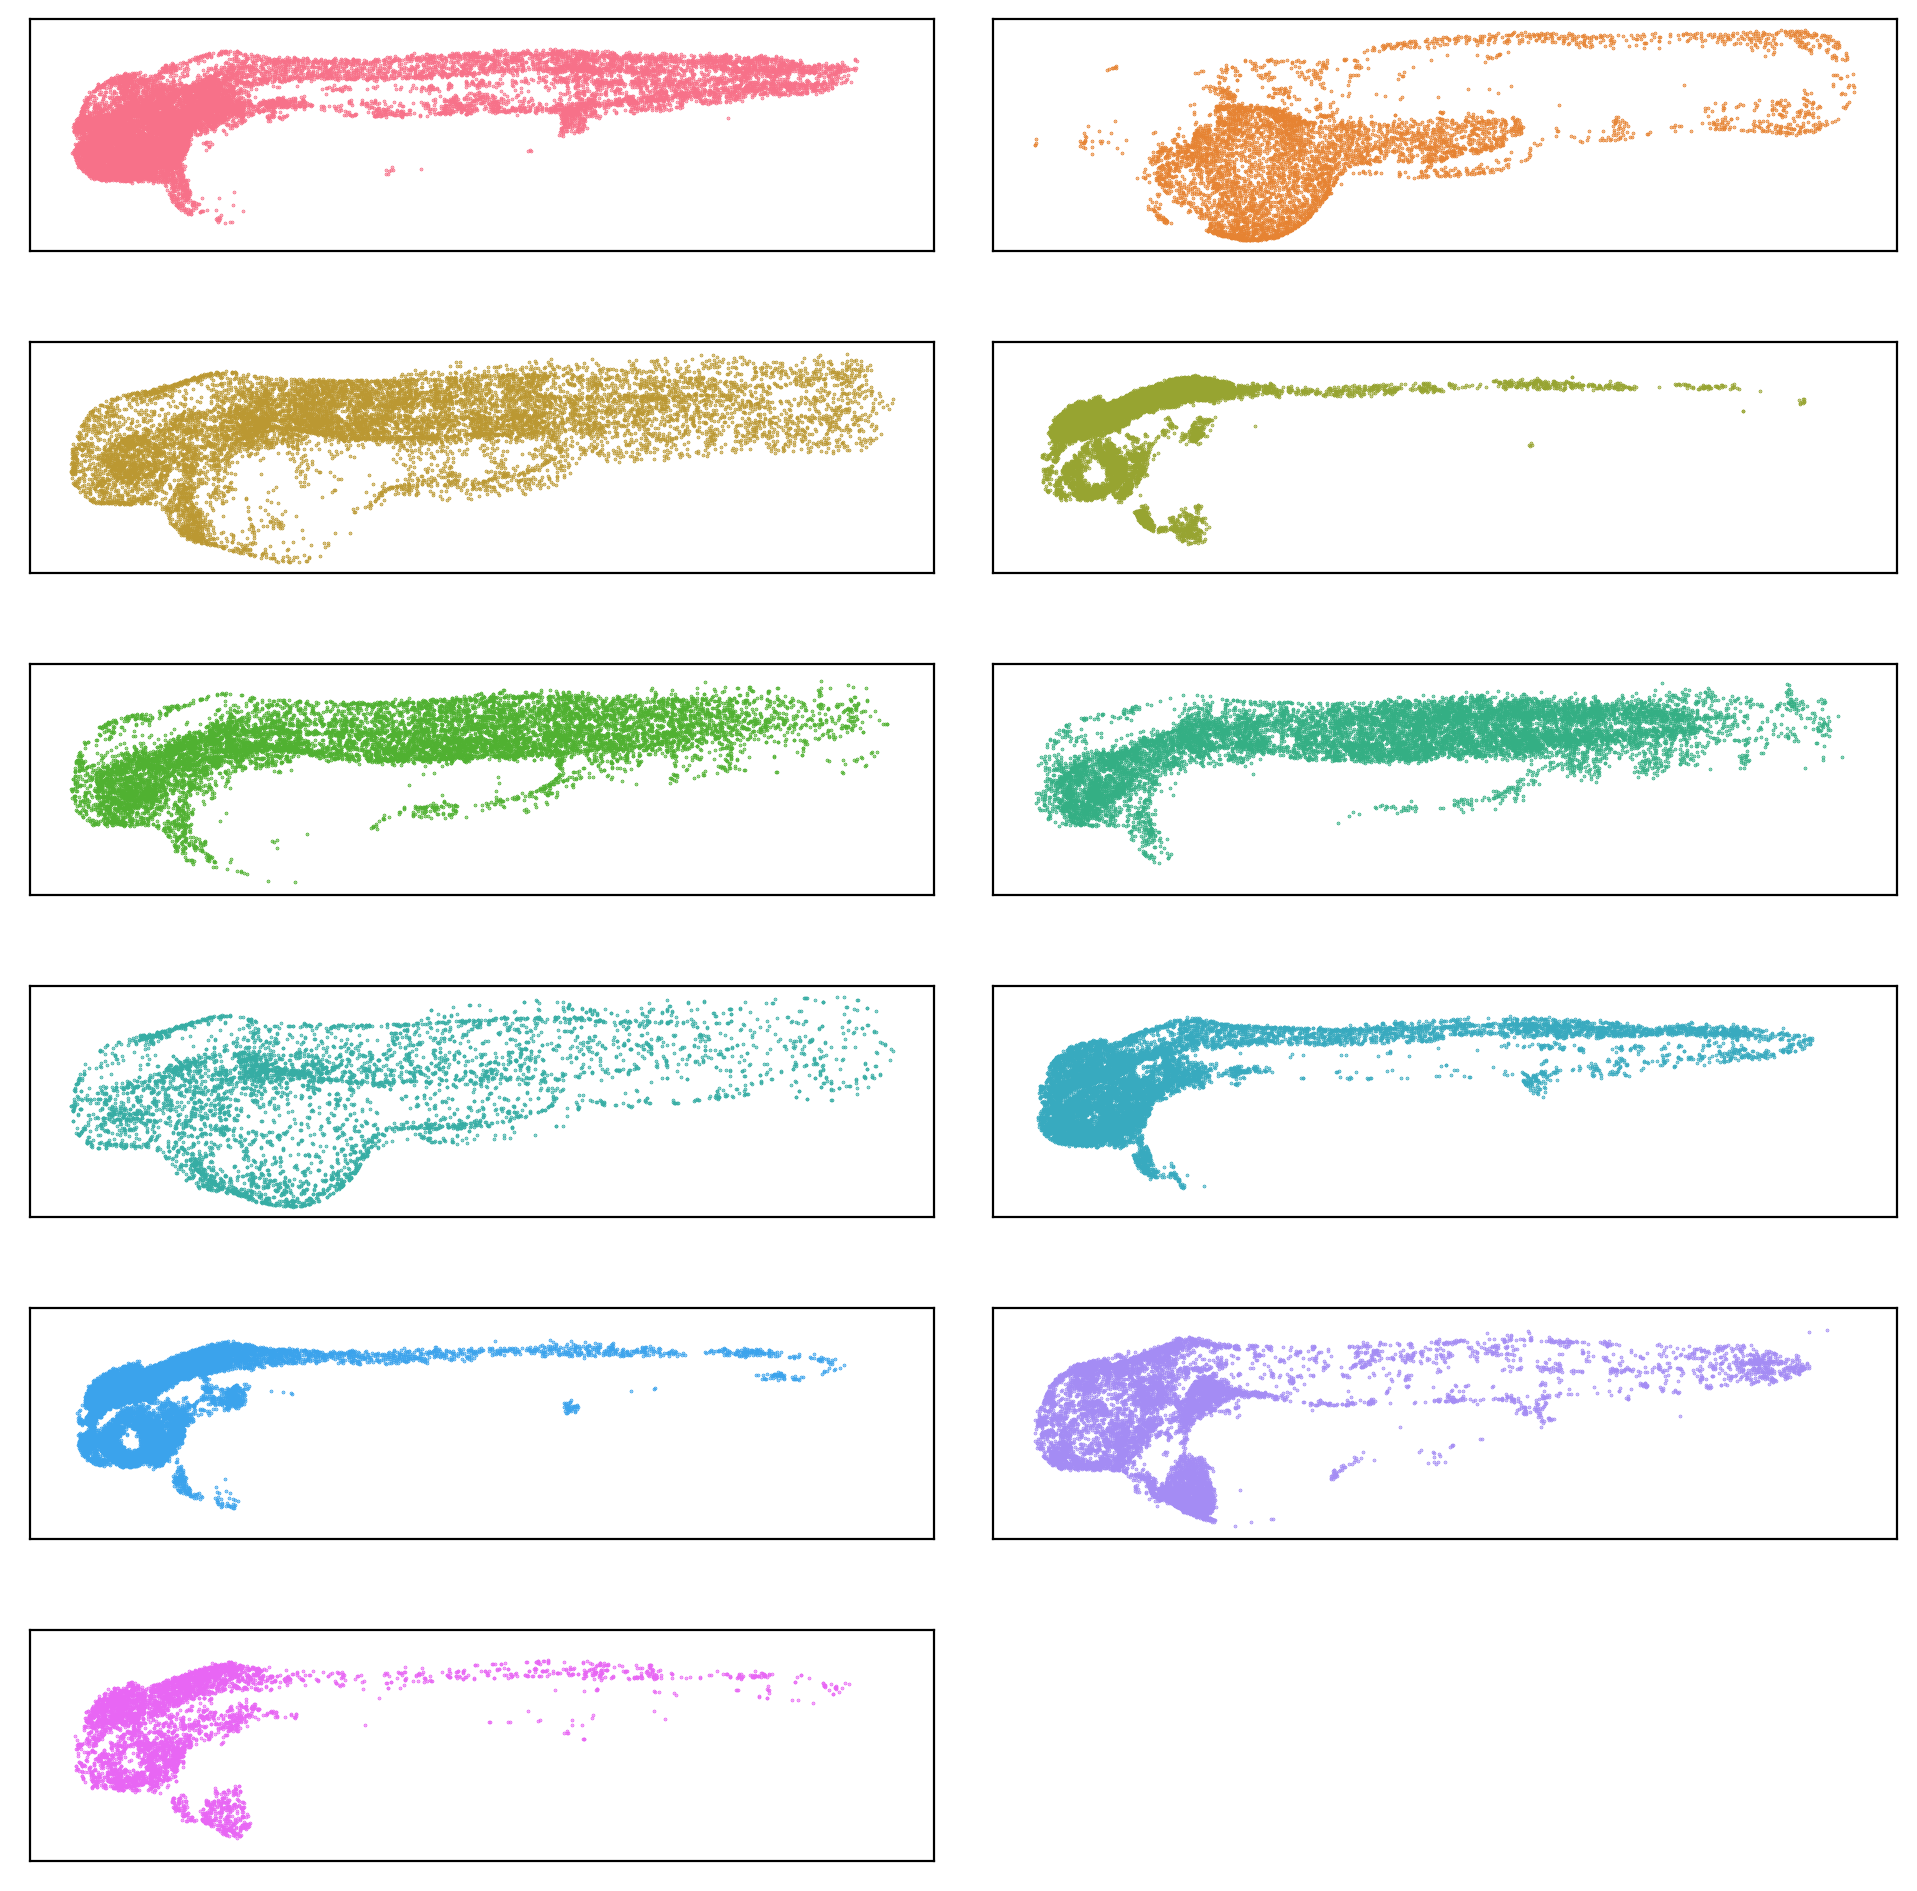

In [101]:
palette = sns.color_palette('husl', n_colors=12)
fig, axs = plt.subplots(6, 2, sharex=True, sharey=True, dpi=200, figsize=(10,10))
axs = axs.flatten()
for m in df['motifs'].unique():
    ax = axs[m]
    ax.scatter(df.loc[df['motifs']==m, 'y'].values, 
               df.loc[df['motifs']==m, 'x'].values,
               color=palette[m],
               s=.1)
    ax.set_aspect('equal')
    ax.invert_yaxis()
fig.delaxes(axs[11])
plt.tight_layout()
plt.yticks([])
plt.xticks([])

Note that the colours are assigned randomly and do not correspond to the ones used in the publication.

## Identify organisational archetypes
We now use Hierarchical Agglomerative Clustering to group motifs with similar organisation. This identifies two classes which we call 'crystalline' and 'amorphous'.

### Visualisation of clustering
We represent the similarity of motifs via a clustermap representation.

Text(668.9999999999999, 0.5, '')

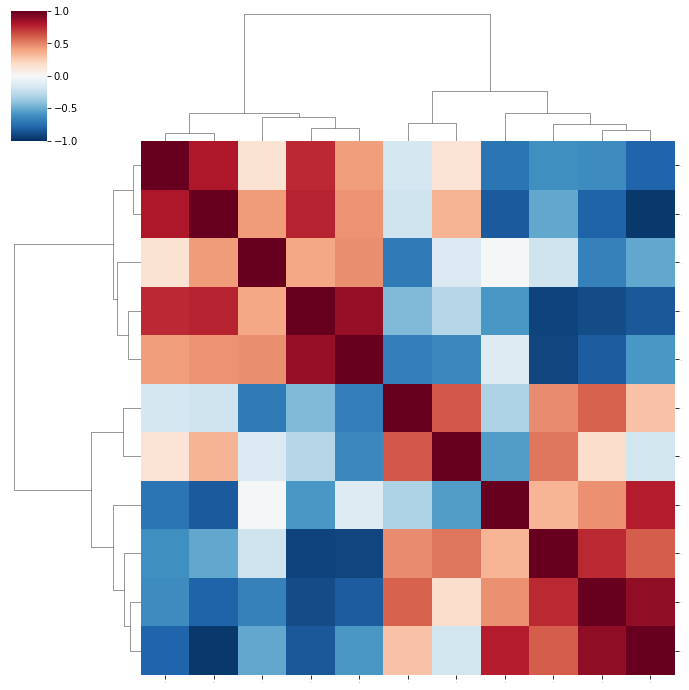

In [123]:
_sdf = df.groupby('motifs').mean()[features_scaled]
g = sns.clustermap(
    data=_sdf.T.corr(),
    cmap='RdBu_r',
    method='ward',
    vmin=-1, vmax=1,
)
plt.setp(g.ax_heatmap.xaxis.get_majorticklabels(), fontsize=0)
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), fontsize=0)
g.ax_heatmap.set_xlabel("", fontsize=14)
g.ax_heatmap.set_ylabel("", fontsize=14)

### Clustering of the data
Here we use the same clustering algorithm as before and assign archetype labels to the data.

In [118]:
_sdf = df.groupby(['motifs']).mean()[features_scaled].reset_index()
X = _sdf[features_scaled]
labels = AgglomerativeClustering(linkage='ward').fit_predict(X)
l_dict = dict(zip(_sdf['motifs'].values, labels))
df['archetypes'] = df['motifs'].map(l_dict)

### Visualisation of spatial distributions
We colour code individual nuclei based on their archetype for visual inspection.

([], [])

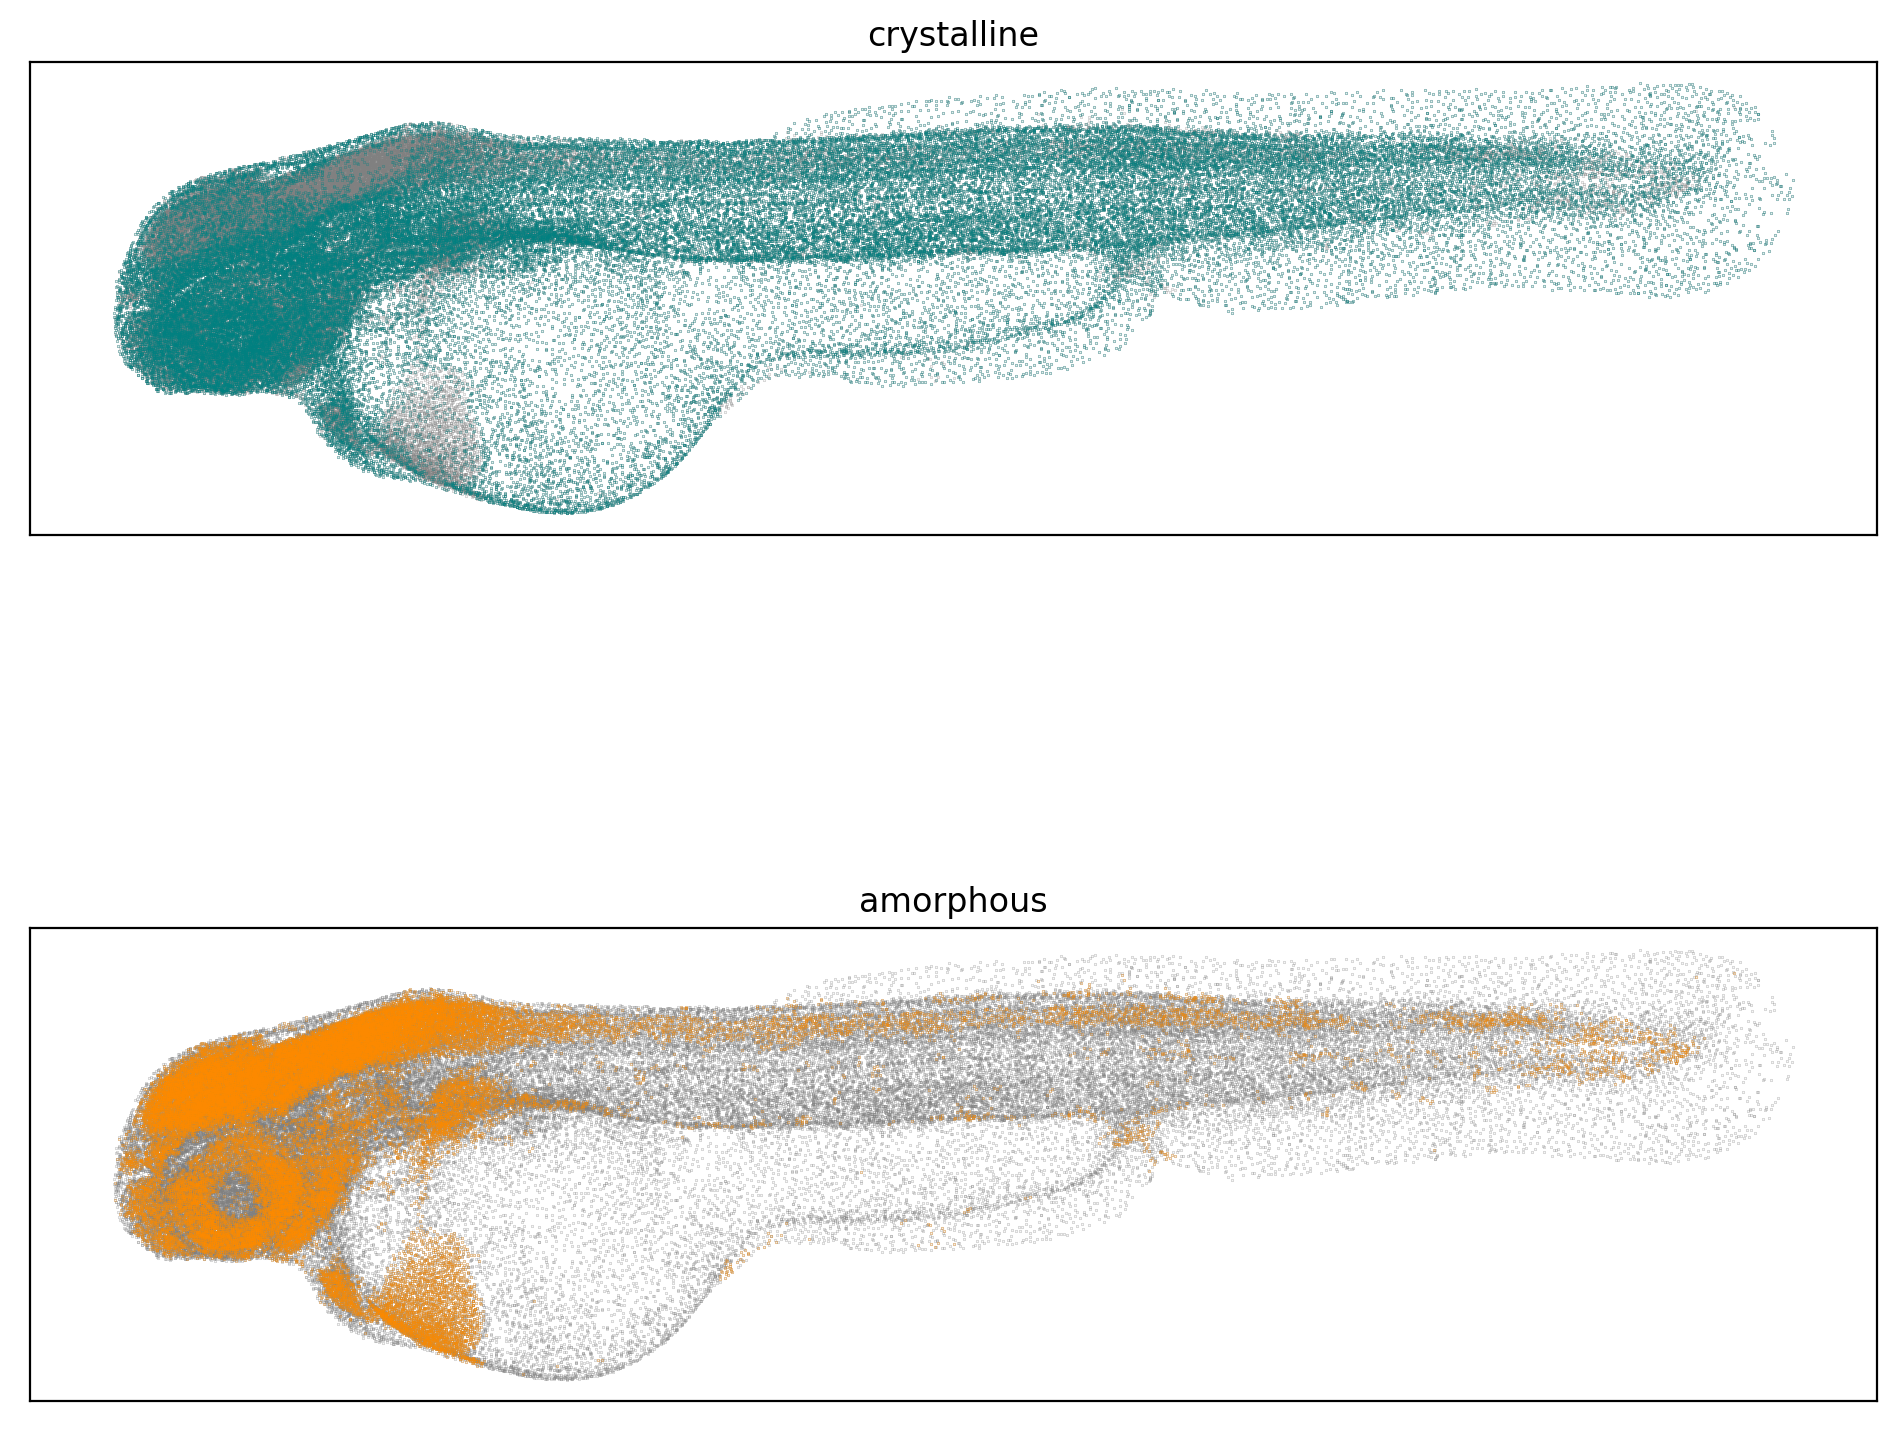

In [133]:
palette = sns.color_palette('husl', n_colors=12)
fig, axs = plt.subplots(2, 1, sharex=True, sharey=True, dpi=200, figsize=(10,10))
axs = axs.flatten()
for m in df['archetypes'].unique():
    ax = axs[m]
    ax.set_title(['crystalline', 'amorphous'][m])
    ax.scatter(df['y'].values, 
               df['x'].values,
               c='grey',
               s=.01)
    ax.scatter(df.loc[df['archetypes']==m, 'y'].values, 
               df.loc[df['archetypes']==m, 'x'].values,
               c=['teal', 'darkorange'][m],
               s=.01)
    
    
    ax.set_aspect('equal')
    
ax.invert_yaxis()
plt.tight_layout()
plt.yticks([])
plt.xticks([])